# ECON 425: Final Project

#### Courtney Manahrt & Martin Jamouss & Arturs Apinis

In [4]:
# Import Necessary Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [6]:
np.random.seed(42)

## **Scope of Project: Predicing Electricity Demanded**
The [Dataset](https://www.kaggle.com/datasets/aramacus/electricity-demand-in-victoria-australia?resource=download) was taken from Kaggle and is used to predict the Demand of Electricity in MWh using a variety of features. Below is a brief description fo the data:

*   **date** : datetime, the date of the recording
*   **demand** : float, a total daily electricity demand in MWh
*   **RRP** : float, a recommended retail price in AUD / MWh
  *   *Note: RRP was negative, so that energy producers were paying consumers rather than vise versa.* 
*   **demand_pos_RRP** : float, a total daily demand at positive RRP in MWh
*   **RRP_positive** : float, an averaged positive RRP, weighted by the corresponding intraday demand in AUD / MWh
*   **demand_neg_RRP** : float, an total daily demand at negative RRP in MWh
*   **RRP_negative** : float, an average negative RRP, weighted by the corresponding intraday demand in AUD / MWh
*   **frac_at_neg_RRP** : float, a fraction of the day when the demand was traded at negative RRP
*   **min_temperature** : float, minimum temperature during the day in Celsius
*   **max_temperature** : float, maximum temperature during the day in Celsius
*   **solar_exposure** : float, total daily sunlight energy in MJ/m^2
*   **rainfall** : float, daily rainfall in mm
*   **school_day** : boolean, if students were at school on that day
*   **holiday** : boolean, if the day was a state or national holiday


In this project, the goal is to build a model that can predict the demand for electricity on a given day, given certain features. To do this we will use the following steps:


1.   **Import and Clean the data** <br>
Cleaning the data includes breaking down the data variable to include a variable that captures the month and day of the month. These will be used in the model

2.  **Feature Selection** <br>
Here we will use a Lasso regression to adjust lambda to do a feature selection to narrow down which features are the most important to use to predict demand. 


3.   **Build Models** <br>
Using the most important features, we will train multiple models. For each model, we will evaluate model performance by varying the training/testing sizes. We will also store the MSEs for both the in sample and out of samples. <br><br>
The models we will learn are:
    - Linear regression
    - Elastic Net Regression
    - KNN with voting
    - Regression Tree with Boosting
    - Feed Forward Neural Network
    - Stacking Models 
<br>

In addition to training the different models, we will also utilize varying training/testing splits and evaluate how each model performs under the different testing sizes. 

4.   **Model Comparison & Selection** <br>
To compare models, we will compare the in-sample and out of sample MSEs across each model. Addtionally, we will evaluate the MSEs across different testing sizes to evaluate the most effecting training/testing split for the models. 
<br><br>
The goal in the model comparison section is to select the best performing model to use for the remainder of the report.  

5.   **Model Evauation & Performance** <br>
With the best performing model selected, we will evaluate the model and interpret its results. Additionally, we will use the model to predict the demand on sample cases (either randomly selecting samples from the dataset or coming up with our own examples). 



### Import & Clean Data

In [7]:
data = pd.read_csv('/content/gdrive/MyDrive/ECON 425/Final Project/complete_dataset.csv')
data = data.dropna()
data.head()

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


Data Processing:
- We need to make 'school_day' and 'holiday' to be dummy variables (1 or 0s) rather than Yes/No. 
- We need to turn 'date' into a datetime variable that we can extract the month and day from 
- We need to create our X (feature vectors) and our y (demand vector) 
- We will scale/normalize the data to make it comparable using the Standard Scaler

In [8]:
# One-hot encode columns school_day and holiday
data = pd.get_dummies(data, columns=['school_day', 'holiday'])

# Drop the columns school_day_no and holiday_no
data = data.drop(['school_day_N', 'holiday_N'], axis=1)

# Rename the columns school_day_yes and holiday_yes
data = data.rename(columns={'school_day_Y': 'school_day', 'holiday_Y': 'holiday'})


In [9]:
# Making Dates 
data['date'] = pd.to_datetime(data['date'])

# Month Feature
data['month'] = [i.month for i in data['date']]
data['day'] = [i.day for i in data['date']]

# Drop the  date column
data = data.drop(['date'], axis=1)


In [10]:
# input variables
X = data.drop(['demand'], axis=1)
# target variable
y = data['demand']

In [11]:
# Scale Data - Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

### Data Exploration & Feature Selection
- We will use a Lasso regression to identify the most important features for our models. Under an optimal lambda, Lasso can act as a natural feature selector.  

In [12]:
## Split the training & testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                test_size=0.2, random_state=42)

13.303781816230847


                  Coefficient
RRP                  0.000000
demand_pos_RRP   14793.821936
RRP_positive         0.000000
demand_neg_RRP    3557.041151
RRP_negative        -0.000000
frac_at_neg_RRP      0.000000
min_temperature     -0.000000
max_temperature     -0.000000
solar_exposure      -0.000000
rainfall            -0.000000
school_day           0.000000
holiday             -0.000000
month               -0.000000
day                 -0.000000




<Figure size 720x432 with 0 Axes>

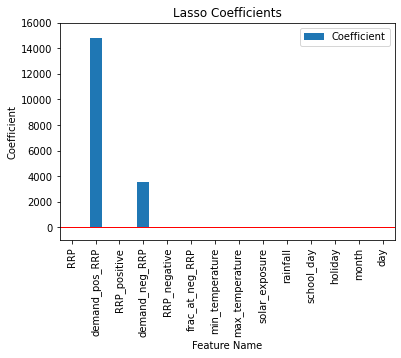

In [13]:
# Use function LassoCV
from sklearn.linear_model import LassoCV

modCV = LassoCV().fit(X_train, y_train)

# Determinging the optimal lambda
lam = modCV.alpha_
print(lam)
print('\n')

# Use the Lasso Function
from sklearn.linear_model import Lasso

mod1 = Lasso(alpha = lam).fit(X_train, y_train)

# get the Coefficients
coefs = mod1.coef_ 

l = list(zip(coefs, X))
coef_name = []
coef = []
for i in range(len(l)):
  coef_name.append(l[i][1])
  coef.append(l[i][0])


coefficients = pd.DataFrame(coef, index = coef_name, columns = ['Coefficient'])
print(coefficients)
print('\n')

plt.figure(figsize = (10, 6))
coefficients.plot(kind='bar')
plt.axhline(0, color = 'red', lw = 1)

plt.ylim([-1000, 16000])
plt.title('Lasso Coefficients')
plt.xlabel('Feature Name')
plt.ylabel('Coefficient')
plt.show()

In [14]:
X_new = X[['RRP', 'RRP_positive',
       'RRP_negative', 'frac_at_neg_RRP', 'min_temperature', 'max_temperature',
       'solar_exposure', 'rainfall', 'school_day', 'holiday', 'month', 'day']]

# Scale Data - Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scale_new = scaler.fit_transform(X_new)

## Split the training & testing data
from sklearn.model_selection import train_test_split

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_scale_new,
                                            y, test_size=0.2, random_state=42)

948.8088112093319


                 Coefficient
RRP              2026.088051
RRP_positive        0.000000
RRP_negative        0.000000
frac_at_neg_RRP -1545.858884
min_temperature  -252.903992
max_temperature     0.000000
solar_exposure  -2655.983250
rainfall         -242.913817
school_day        132.618456
holiday         -2118.351780
month             -22.003446
day                 0.000000




<Figure size 1080x432 with 0 Axes>

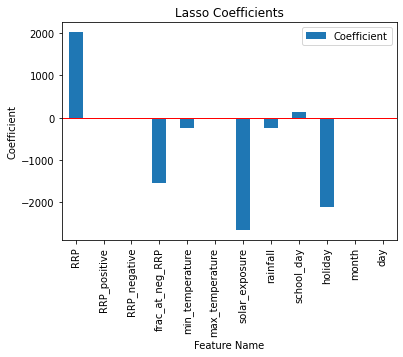

In [15]:
# Use function LassoCV
from sklearn.linear_model import LassoCV

modCV = LassoCV().fit(X_train_new, y_train_new)

# Determinging the optimal lambda
lam = modCV.alpha_
print(lam)
print('\n')

# Use the Lasso Function
from sklearn.linear_model import Lasso

mod2 = Lasso(alpha = lam).fit(X_train_new, y_train_new)

# get the Coefficients
coefs = mod2.coef_

l = list(zip(coefs, X_new))
coef_name = []
coef = []
for i in range(len(l)):
  coef_name.append(l[i][1])
  coef.append(l[i][0])


coefficients = pd.DataFrame(coef, index = coef_name, columns = ['Coefficient'])
print(coefficients)
print('\n')

plt.figure(figsize = (15, 6))
coefficients.plot(kind='bar')
plt.axhline(0, color = 'red', lw = 1)
plt.title('Lasso Coefficients')
plt.xlabel('Feature Name')
plt.ylabel('Coefficient')
plt.show()

Since Lasso brings multiple coefficients to 0, we will use the non-zero coefficients throughout the remainder of the project. The non-zero coefficients are:

*   RRP
*   frac_at_neg_RRP
*   min_temperature
*   solar_exposure
*   rainfall
*   school_day
*   holiday
*   month



In [16]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

X_data = X[['RRP', 'frac_at_neg_RRP', 'min_temperature', 'solar_exposure',
            'rainfall','school_day','holiday','month']]
X_data_scale = scaler.fit_transform(X_data)
y_data = y

### Build Models 

#### 1. Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Define the splits you want to use for cross-validation
splits = [0.1, 0.2, 0.3, 0.4, 0.5]

data_X = [X_data, X_data_scale]
names = ['Unscaled', 'Scaled']
linreg_scores = pd.DataFrame()

for i in range(len(data_X)):
  data = data_X[i]
  name = names[i]
  print(name)
  # Create an empty list to store the mean squared error for each split
  in_mse_scores = []
  out_mse_scores = []
  cross_val = []

  for split in splits:
      # Split the data into training and testing sets using the current split
      X_train, X_test, y_train, y_test = train_test_split(data, y_data, 
                                            test_size=split, random_state=42)
      
      # Train a linear regression model on the training data
      lin_model = LinearRegression().fit(X_train, y_train)
      

      ### In Sample & Out of Sample MSEs
        # Use the trained model to predict the target variable on the test data
      lin_pred = lin_model.predict(X_test)

      # Calculate the mean squared error of the predictions
      lin_mse = mean_squared_error(y_test, lin_pred)
      
      
      # Store the mean squared error in the list
      out_mse_scores.append(lin_mse)

        # In sample MSE
      lin_pred = lin_model.predict(X_train)

      # Calculate the mean squared error of the predictions
      lin_mse = mean_squared_error(y_train, lin_pred)
      

      # Store the mean squared error in the list
      in_mse_scores.append(lin_mse)

      ## Cross Validation
      score = cross_val_score(lin_model, X_train, y_train, cv = 5, 
                              scoring = 'neg_mean_squared_error')
      score = score *-1
      score = score.mean()
      cross_val.append(score)


  # Find the best split size and corresponding mean squared error
  best_mse = min(cross_val)
  best_split = splits[cross_val.index(best_mse)]

  # Print the best split size and corresponding mean squared error
  print("Best split size: {:.1f}, Best MSE: {:}".format(best_split, best_mse))
  print('\n')

  # Storing Results in a DataFrame
  linreg = pd.DataFrame({'In_Sample_MSE_{}'.format(name): in_mse_scores, 
                        'Out_Sample_MSE_{}'.format(name) :out_mse_scores,
                         'Cross_Val_MSE_{}'.format(name) :out_mse_scores},
                        index = splits)
  linreg_scores = pd.concat([linreg_scores, linreg], axis = 1)

linreg_scores


Unscaled
Best split size: 0.5, Best MSE: 139637387.09672174


Scaled
Best split size: 0.5, Best MSE: 139637387.0967217




,In_Sample_MSE_Unscaled,Out_Sample_MSE_Unscaled,Cross_Val_MSE_Unscaled,In_Sample_MSE_Scaled,Out_Sample_MSE_Scaled,Cross_Val_MSE_Scaled
0.1,1.483082e+08,1.364229e+08,1.364229e+08,1.483082e+08,1.364229e+08,1.364229e+08
0.2,1.463671e+08,1.503473e+08,1.503473e+08,1.463671e+08,1.503473e+08,1.503473e+08
0.3,1.383394e+08,2.241257e+08,2.241257e+08,1.383394e+08,2.241257e+08,2.241257e+08
0.4,1.368715e+08,2.049151e+08,2.049151e+08,1.368715e+08,2.049151e+08,2.049151e+08
0.5,1.351122e+08,1.871158e+08,1.871158e+08,1.351122e+08,1.871158e+08,1.871158e+08


In [18]:
out_mse = linreg_scores[['Cross_Val_MSE_Unscaled', 'Cross_Val_MSE_Scaled']]
min_mse = out_mse.min()

## Based on the best Model:
split = out_mse.idxmin()[0]
data_is_scale = min_mse.idxmin()

if data_is_scale == 'Cross_Val_MSE_Unscaled':
  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                          test_size=split, random_state=42)
elif data_is_scale == 'Cross_Val_MSE_Scaled':
  X_train, X_test, y_train, y_test = train_test_split(X_data_scale, y_data, 
                                          test_size=split, random_state=42)

# Train a linear regression model on the training data
lin_model = LinearRegression().fit(X_train, y_train)


#### 2. Elastic Net model

In [19]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Define the splits you want to use for cross-validation
splits = [0.1,0.2, 0.3, 0.4, 0.5]

data_X = [X_data, X_data_scale]
names = ['Unscaled', 'Scaled']
en_scores = pd.DataFrame()

for i in range(len(data_X)):
  data = data_X[i]
  name = names[i]
  print(name)

  # Create an empty list to store the mean squared error for each split
  in_mse_scores = []
  out_mse_scores = []
  grid_params = []
  cross_val = []

  for split in splits:
      # Split the data into training/testing sets using the current split size
      X_train, X_test, y_train, y_test = train_test_split(data, y_data,
                                            test_size=split, random_state=42)

      # create Elastic Net model
      elastic_net = ElasticNet()

      # set up parameter grid for cross-validation
      param_grid = {
          'alpha': [0.1, 1, 10],
          'l1_ratio': [0.1, 0.5, 0.9]
      }

      # create GridSearchCV object
      grid_search = GridSearchCV(elastic_net, param_grid, 
                            cv=5, scoring='neg_mean_squared_error', 
                            return_train_score=True)

      # fit the model to the training data using cross-validation
      grid_search.fit(X_train, y_train)

      # get the best hyperparameters and model
      best_params = grid_search.best_params_
      grid_params.append(best_params)

      en_model = grid_search.best_estimator_

        ## Out of Sample
      # make predictions on the testing data using the best model
      en_pred = en_model.predict(X_test)

      # calculate the mean squared error
      mse = mean_squared_error(y_test, en_pred)

      # append the mean squared error to the list
      out_mse_scores.append(mse)

        ## In- Sample
      # make predictions on the testing data using the best model
      en_pred = en_model.predict(X_train)

      # calculate the mean squared error
      mse = mean_squared_error(y_train, en_pred)

      # append the mean squared error to the list
      in_mse_scores.append(mse)


      ## Cross Validation
      score = cross_val_score(en_model, X_train, y_train, cv = 5, 
                              scoring = 'neg_mean_squared_error')
      score = score *-1
      score = score.mean()
      cross_val.append(score)

  # Find the best split size and corresponding mean squared error
  best_mse = min(cross_val)
  best_split = splits[cross_val.index(best_mse)]
  best_params = grid_params[cross_val.index(best_mse)]

  # Print the best split size and corresponding mean squared error
  print("Best split size: {:.1f}, Best MSE: {:}, Best Params: {:}".format(best_split,
                                                        best_mse, best_params))
  print('\n')

  # Storing Results in a DataFrame
  en = pd.DataFrame({'In_Sample_MSE_{}'.format(name): in_mse_scores, 
                        'Out_Sample_MSE_{}'.format(name) :out_mse_scores,
                     'Cross_Val_MSE_{}'.format(name): cross_val,
                        'Grid Params {}'.format(name) : grid_params},
                        index = splits)
  
  en_scores = pd.concat([en_scores, en], axis = 1)

en_scores


Unscaled
Best split size: 0.5, Best MSE: 142667758.54273915, Best Params: {'alpha': 0.1, 'l1_ratio': 0.9}


Scaled
Best split size: 0.5, Best MSE: 139548389.11797377, Best Params: {'alpha': 0.1, 'l1_ratio': 0.9}




,In_Sample_MSE_Unscaled,Out_Sample_MSE_Unscaled,Cross_Val_MSE_Unscaled,Grid Params Unscaled,In_Sample_MSE_Scaled,Out_Sample_MSE_Scaled,Cross_Val_MSE_Scaled,Grid Params Scaled
0.1,1.527445e+08,1.375387e+08,1.830431e+08,"{'alpha': 0.1, 'l1_ratio': 0.9}",1.523795e+08,1.362089e+08,1.545413e+08,"{'alpha': 1, 'l1_ratio': 0.5}"
0.2,1.505094e+08,1.553584e+08,1.760276e+08,"{'alpha': 0.1, 'l1_ratio': 0.9}",1.504807e+08,1.527469e+08,1.530096e+08,"{'alpha': 1, 'l1_ratio': 0.5}"
0.3,1.416393e+08,2.417212e+08,1.443003e+08,"{'alpha': 0.1, 'l1_ratio': 0.9}",1.383587e+08,2.174270e+08,1.409056e+08,"{'alpha': 0.1, 'l1_ratio': 0.9}"
0.4,1.400831e+08,2.215387e+08,1.437149e+08,"{'alpha': 0.1, 'l1_ratio': 0.9}",1.368950e+08,1.986240e+08,1.402903e+08,"{'alpha': 0.1, 'l1_ratio': 0.9}"
0.5,1.381912e+08,1.997692e+08,1.426678e+08,"{'alpha': 0.1, 'l1_ratio': 0.9}",1.351323e+08,1.830578e+08,1.395484e+08,"{'alpha': 0.1, 'l1_ratio': 0.9}"


In [20]:
out_mse = en_scores[['Cross_Val_MSE_Unscaled', 'Cross_Val_MSE_Scaled']]
min_mse = out_mse.min()

params = en_scores[['Grid Params Unscaled', 'Grid Params Scaled']]

## Based on the best Model:
split = out_mse.idxmin()[0]
data_is_scale = min_mse.idxmin()

if data_is_scale == 'Cross_Val_MSE_Unscaled':
  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                          test_size=split, random_state=42)
  best_params = params['Grid Params Unscaled'][split]

elif data_is_scale == 'Cross_Val_MSE_Scaled':
  X_train, X_test, y_train, y_test = train_test_split(X_data_scale, y_data, 
                                          test_size=split, random_state=42)
  best_params = params['Grid Params Scaled'][split]

alpha = best_params['alpha']
l1_ratio = best_params['l1_ratio']


# Build the Model
en_model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio).fit(X_train, y_train)

#### 3. Regression tree

In [21]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Define the splits you want to use for cross-validation
splits = [0.1, 0.2, 0.3, 0.4, 0.5]

data_X = [X_data, X_data_scale]
names = ['Unscaled', 'Scaled']
regtree_scores = pd.DataFrame()

for i in range(len(data_X)):
  data = data_X[i]
  name = names[i]
  print(name)
  # Create an empty list to store the mean squared error for each split
  in_mse_scores = []
  out_mse_scores = []
  grid_params = []
  cross_val = []

  for split in splits:
      print(split)
  # Split the data into training and testing sets using the current split size
      X_train, X_test, y_train, y_test = train_test_split(data, y_data, 
                                            test_size=split, random_state=42)

      # Define the hyperparameter grid
      param_grid = {
          'base_estimator__max_depth': [2,3,4,5,6],
          'n_estimators': [100, 200, 300],
          'learning_rate': [0.01, 0.1]
      }

      # Create the base estimator
      estimator = DecisionTreeRegressor()

      # Create the AdaBoost regressor
      ada_regressor = AdaBoostRegressor(base_estimator=estimator)

      # Perform cross-validation to find the best hyperparameters
      grid_search = GridSearchCV(ada_regressor, param_grid=param_grid, cv=5)
      grid_search.fit(X_train, y_train)

      # get the best hyperparameters and model
      best_params = grid_search.best_params_
      grid_params.append(best_params)
      
      # Train the model with the best hyperparameters
      best_regressor = grid_search.best_estimator_
      best_regressor.fit(X_train, y_train)


        ## Out of Sample
      # Make predictions on the testing set
      y_pred = best_regressor.predict(X_test)

      # Calculate the mean squared error
      mse = mean_squared_error(y_test, y_pred)
      print('Mean squared error: %.2f' % mse)
      print(grid_search.best_params_)

      # append the mean squared error to the list
      out_mse_scores.append(mse)

        ## In Sample
      # Make predictions on the testing set
      y_pred = best_regressor.predict(X_train)

      # Calculate the mean squared error
      mse = mean_squared_error(y_train, y_pred)

      # append the mean squared error to the list
      in_mse_scores.append(mse)

      ## Cross Validation
      score = cross_val_score(best_regressor, X_train, y_train, cv = 5, 
                              scoring = 'neg_mean_squared_error')
      score = score *-1
      score = score.mean()
      cross_val.append(score)

  # Find the best split size and corresponding mean squared error
  best_mse = min(cross_val)
  best_split = splits[cross_val.index(best_mse)]

  # Print the best split size and corresponding mean squared error
  print('\n')
  print("Best split size: {:.1f}, Best MSE: {:}".format(best_split, best_mse)) 
  print('\n')

  # Storing Results in a DataFrame
  rt_score = pd.DataFrame({'In_Sample_MSE_{}'.format(name): in_mse_scores, 
                        'Out_Sample_MSE_{}'.format(name):out_mse_scores,
                        'Cross_Val_MSE_{}'.format(name): cross_val,
                        'Grid Params {}'.format(name) : grid_params},
                        index = splits)
  regtree_scores = pd.concat([regtree_scores, rt_score], axis = 1)

regtree_scores

Unscaled
0.1
Mean squared error: 100112348.06
{'base_estimator__max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 200}
0.2
Mean squared error: 97553922.03
{'base_estimator__max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 300}
0.3
Mean squared error: 99563969.21
{'base_estimator__max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 300}
0.4
Mean squared error: 100640983.25
{'base_estimator__max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 100}
0.5
Mean squared error: 99612591.45
{'base_estimator__max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 200}


Best split size: 0.2, Best MSE: 92485440.97389266


Scaled
0.1
Mean squared error: 99178330.38
{'base_estimator__max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 300}
0.2
Mean squared error: 98292431.58
{'base_estimator__max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 300}
0.3
Mean squared error: 100192936.27
{'base_estimator__max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 300}
0.4
Mean squared error: 9992977

,In_Sample_MSE_Unscaled,Out_Sample_MSE_Unscaled,Cross_Val_MSE_Unscaled,Grid Params Unscaled,In_Sample_MSE_Scaled,Out_Sample_MSE_Scaled,Cross_Val_MSE_Scaled,Grid Params Scaled
0.1,6.807196e+07,1.001123e+08,9.429287e+07,"{'base_estimator__max_depth': 6, 'learning_rat...",6.600959e+07,9.917833e+07,9.429288e+07,"{'base_estimator__max_depth': 6, 'learning_rat..."
0.2,6.587962e+07,9.755392e+07,9.248544e+07,"{'base_estimator__max_depth': 6, 'learning_rat...",6.503680e+07,9.829243e+07,9.321667e+07,"{'base_estimator__max_depth': 6, 'learning_rat..."
0.3,6.377898e+07,9.956397e+07,9.393935e+07,"{'base_estimator__max_depth': 6, 'learning_rat...",6.464352e+07,1.001929e+08,9.452851e+07,"{'base_estimator__max_depth': 6, 'learning_rat..."
0.4,6.562243e+07,1.006410e+08,9.675993e+07,"{'base_estimator__max_depth': 6, 'learning_rat...",6.218355e+07,9.992978e+07,9.643529e+07,"{'base_estimator__max_depth': 6, 'learning_rat..."
0.5,5.906083e+07,9.961259e+07,9.769622e+07,"{'base_estimator__max_depth': 6, 'learning_rat...",5.917494e+07,1.010933e+08,9.803682e+07,"{'base_estimator__max_depth': 6, 'learning_rat..."


In [22]:
out_mse = regtree_scores[['Cross_Val_MSE_Unscaled', 'Cross_Val_MSE_Scaled']]
min_mse = out_mse.min()

params = regtree_scores[['Grid Params Unscaled', 'Grid Params Scaled']]

## Based on the best Model:
split = out_mse.idxmin()[0]
data_is_scale = min_mse.idxmin()

if data_is_scale == 'Cross_Val_MSE_Uncaled':
  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                          test_size=split, random_state=42)
  best_params = params['Grid Params Unscaled'][split]

elif data_is_scale == 'Cross_Val_MSE_Scaled':
  X_train, X_test, y_train, y_test = train_test_split(X_data_scale, y_data, 
                                          test_size=split, random_state=42)
  best_params = params['Grid Params Scaled'][split]

max_depth = best_params['base_estimator__max_depth']
n_estimator = best_params['n_estimators']
l_rate = best_params['learning_rate']


# Build the Model
# Create the base estimator
estimator = DecisionTreeRegressor(max_depth = max_depth)

# Create the AdaBoost regressor
regtree_model = AdaBoostRegressor(base_estimator=estimator, 
                           n_estimators= n_estimator, learning_rate= l_rate)
regtree_model.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6),
                  learning_rate=0.1, n_estimators=200)

#### 4. k-nearest neighbors model

In [23]:
from sklearn.neighbors import KNeighborsRegressor

# Define the splits you want to use for cross-validation
splits = [0.1, 0.2, 0.3, 0.4, 0.5]

data_X = [X_data, X_data_scale]
names = ['Unscaled', 'Scaled']
knn_scores = pd.DataFrame()

for i in range(len(data_X)):
  data = data_X[i]
  name = names[i]
  print(name)
  # Create an empty list to store the mean squared error for each split
  in_mse_scores = []
  out_mse_scores = []
  grid_params = []
  cross_val = []

  for split in splits:
      # Split the data into training/testing sets using the current split size
      X_train, X_test, y_train, y_test = train_test_split(data, y_data, 
                                              test_size=split, random_state=42)

      # create KNN model
      knn = KNeighborsRegressor()

      # set up parameter grid for cross-validation
      param_grid = {
          'n_neighbors': [1, 2, 3, 5, 7, 10]
      }

      # create GridSearchCV object
      grid_search = GridSearchCV(knn, param_grid, cv=5, 
                                 scoring='neg_mean_squared_error')

      # fit the model to the training data using cross-validation
      grid_search.fit(X_train, y_train)

      # get the best hyperparameters and model
      params = grid_search.best_params_

      grid_params.append(params)

      knn_model = grid_search.best_estimator_


        ## Out of Sample
      # make predictions on the testing data
      knn_pred = knn_model.predict(X_test)

      # calculate the MSE 
      out_mse = mean_squared_error(y_test, knn_pred)

      # append the mean squared error to the list
      out_mse_scores.append(out_mse)

        ## In Sample
      # make predictions on the testing data
      knn_pred = knn_model.predict(X_train)

      # calculate the MSE 
      in_mse = mean_squared_error(y_train, knn_pred)

      # append the mean squared error to the list
      in_mse_scores.append(in_mse)

        ## Cross Validation
      score = cross_val_score(knn_model, X_train, y_train, cv = 5, 
                              scoring = 'neg_mean_squared_error')
      score = score *-1
      score = score.mean()
      cross_val.append(score)

      # print the best hyperparameters and mean squared error for the current split size
      print("For split size {:.1f}, Best hyperparameters: {}, MSE: {:.3f}".format(split, params, out_mse))

  # Find the best split size and corresponding mean squared error
  best_mse = min(cross_val)
  best_split = splits[cross_val.index(best_mse)]
  best_params = grid_params[cross_val.index(best_mse)]

  # Print the best split size and corresponding mean squared error
  print('n')
  print("Best split size: {:.1f}, Best MSE: {:.3f}, Best Parameters: {:}".format(best_split, best_mse, best_params))
  print('\n')


  # Storing Results in a DataFrame
  knnscores = pd.DataFrame({'In_Sample_MSE_{}'.format(name): in_mse_scores, 
                        'Out_Sample_MSE_{}'.format(name):out_mse_scores,
                        'Cross_Val_MSE_{}'.format(name): cross_val,
                        'Neighbors_{}'.format(name): grid_params},
                        index = splits)
  
  knn_scores = pd.concat([knn_scores, knnscores], axis = 1)

knn_scores

Unscaled
For split size 0.1, Best hyperparameters: {'n_neighbors': 10}, MSE: 119088704.245
For split size 0.2, Best hyperparameters: {'n_neighbors': 10}, MSE: 134160939.116
For split size 0.3, Best hyperparameters: {'n_neighbors': 10}, MSE: 129885790.733
For split size 0.4, Best hyperparameters: {'n_neighbors': 10}, MSE: 133032460.946
For split size 0.5, Best hyperparameters: {'n_neighbors': 10}, MSE: 129837372.388
n
Best split size: 0.2, Best MSE: 114766194.677, Best Parameters: {'n_neighbors': 10}


Scaled
For split size 0.1, Best hyperparameters: {'n_neighbors': 10}, MSE: 106653394.204
For split size 0.2, Best hyperparameters: {'n_neighbors': 10}, MSE: 111235074.257
For split size 0.3, Best hyperparameters: {'n_neighbors': 10}, MSE: 110240471.740
For split size 0.4, Best hyperparameters: {'n_neighbors': 10}, MSE: 113329986.439
For split size 0.5, Best hyperparameters: {'n_neighbors': 10}, MSE: 112844016.378
n
Best split size: 0.2, Best MSE: 102515287.615, Best Parameters: {'n_neighb

,In_Sample_MSE_Unscaled,Out_Sample_MSE_Unscaled,Cross_Val_MSE_Unscaled,Neighbors_Unscaled,In_Sample_MSE_Scaled,Out_Sample_MSE_Scaled,Cross_Val_MSE_Scaled,Neighbors_Scaled
0.1,9.406714e+07,1.190887e+08,1.157701e+08,{'n_neighbors': 10},8.187684e+07,1.066534e+08,1.037193e+08,{'n_neighbors': 10}
0.2,9.194903e+07,1.341609e+08,1.147662e+08,{'n_neighbors': 10},8.140194e+07,1.112351e+08,1.025153e+08,{'n_neighbors': 10}
0.3,9.266247e+07,1.298858e+08,1.154312e+08,{'n_neighbors': 10},8.229258e+07,1.102405e+08,1.041894e+08,{'n_neighbors': 10}
0.4,9.280826e+07,1.330325e+08,1.156168e+08,{'n_neighbors': 10},8.422209e+07,1.133300e+08,1.044910e+08,{'n_neighbors': 10}
0.5,9.524464e+07,1.298374e+08,1.177788e+08,{'n_neighbors': 10},8.621376e+07,1.128440e+08,1.068516e+08,{'n_neighbors': 10}


In [24]:
out_mse = knn_scores[['Cross_Val_MSE_Unscaled', 'Cross_Val_MSE_Scaled']]
min_mse = out_mse.min()

params = knn_scores[['Neighbors_Unscaled', 'Neighbors_Scaled']]

## Based on the best Model:
split = out_mse.idxmin()[0]
data_is_scale = min_mse.idxmin()

if data_is_scale == 'Cross_Val_MSE_Unscaled':
  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                          test_size=split, random_state=42)
  best_params = params['Neighbors_Unscaled'][split]

elif data_is_scale == 'Cross_Val_MSE_Scaled':
  X_train, X_test, y_train, y_test = train_test_split(X_data_scale, y_data, 
                                          test_size=split, random_state=42)
  best_params = params['Neighbors_Scaled'][split]

n_neighbors = best_params['n_neighbors']

# create KNN model
knn_model = KNeighborsRegressor(n_neighbors = n_neighbors).fit(X_train, y_train)

#### 5. Feed Forward Neural Network (FFNN)

In [25]:
from sklearn.neural_network import MLPRegressor

# Define the splits you want to use for cross-validation
splits = [0.1, 0.2, 0.3, 0.4, 0.5]

data_X = [X_data, X_data_scale]
names = ['Unscaled', 'Scaled']
ffnn_scores = pd.DataFrame()

for i in range(len(data_X)):
  data = data_X[i]
  name = names[i]
  print(name)
  # Create an empty list to store the mean squared error for each split
  in_mse_scores = []
  out_mse_scores = []
  grid_params = []
  cross_val = []

  for split in splits:
    # Split the data into training and testing sets using the current split size
    X_train, X_test, y_train, y_test = train_test_split(data, y_data, 
                                            test_size=split, random_state=42)

    mlp = MLPRegressor()
    parameters = {'hidden_layer_sizes': [(10, 30, 50, 70,), (10, 30, 50,), 
                                         (10, 20, 40, 60,)],  
                  'alpha': [0.01, 0.1]}

    # Create an instance of the GridSearchCV class
    grid = GridSearchCV(mlp, parameters, cv=5)

    # Train the model using grid search
    grid.fit(X_train, y_train)

    # get the best hyperparameters and model
    params = grid.best_params_
    
    mlp_model = grid.best_estimator_

      ## Out of Sample
    # make predictions on the testing data
    mlp_pred = mlp_model.predict(X_test)

    # calculate the MSE 
    mse = mean_squared_error(y_test, mlp_pred)

    # append the mean squared error to the list
    out_mse_scores.append(mse)

      ## In Sample
    # make predictions on the testing data
    mlp_pred = mlp_model.predict(X_train)

    # calculate the MSE 
    mse = mean_squared_error(y_train, mlp_pred)

    # append the mean squared error to the list
    in_mse_scores.append(mse)

    ## Cross Validation
    score = cross_val_score(mlp_model, X_train, y_train, cv = 5, 
                            scoring = 'neg_mean_squared_error')
    score = score *-1
    score = score.mean()
    cross_val.append(score)

    grid_params.append(params)
    print('Best Parameters:', grid.best_params_)
    print('Best Score:', grid.best_score_)

  # Find the best split size and corresponding mean squared error
  best_mse = min(cross_val)
  best_split = splits[cross_val.index(best_mse)]
  best_params = grid_params[cross_val.index(best_mse)]

  # Print the best split size and corresponding mean squared error
  print('\n')
  print("Best split size: {:.1f}, Best MSE: {:.3f}, Best Paramerters: {:}".format(best_split, best_mse, best_params))
  print('\n')

  # Storing Results in a DataFrame
  ffnnscores = pd.DataFrame({'In_Sample_MSE_{}'.format(name): in_mse_scores, 
                        'Out_Sample_MSE_{}'.format(name):out_mse_scores,
                        'Cross_Val_MSE_{}'.format(name) : cross_val,
                        'Grid Params_{}'.format(name): grid_params},
                        index = splits)
  
  ffnn_scores = pd.concat([ffnn_scores, ffnnscores], axis = 1)

ffnn_scores

Unscaled
Best Parameters: {'alpha': 0.1, 'hidden_layer_sizes': (10, 30, 50, 70)}
Best Score: -5.025595682867795
Best Parameters: {'alpha': 0.1, 'hidden_layer_sizes': (10, 30, 50, 70)}
Best Score: -5.452964333637309
Best Parameters: {'alpha': 0.1, 'hidden_layer_sizes': (10, 30, 50, 70)}
Best Score: -4.705583424025567
Best Parameters: {'alpha': 0.1, 'hidden_layer_sizes': (10, 30, 50, 70)}
Best Score: -5.64962981892967
Best Parameters: {'alpha': 0.01, 'hidden_layer_sizes': (10, 30, 50, 70)}
Best Score: -5.655833983561694


Best split size: 0.3, Best MSE: 1005210475.649, Best Paramerters: {'alpha': 0.1, 'hidden_layer_sizes': (10, 30, 50, 70)}


Scaled
Best Parameters: {'alpha': 0.01, 'hidden_layer_sizes': (10, 30, 50, 70)}
Best Score: -0.020386691664000443
Best Parameters: {'alpha': 0.1, 'hidden_layer_sizes': (10, 30, 50, 70)}
Best Score: -0.02819515557948089
Best Parameters: {'alpha': 0.01, 'hidden_layer_sizes': (10, 20, 40, 60)}
Best Score: -0.08615987069678246
Best Parameters: {'alpha':

,In_Sample_MSE_Unscaled,Out_Sample_MSE_Unscaled,Cross_Val_MSE_Unscaled,Grid Params_Unscaled,In_Sample_MSE_Scaled,Out_Sample_MSE_Scaled,Cross_Val_MSE_Scaled,Grid Params_Scaled
0.1,6.256503e+08,6.555486e+08,1.362765e+09,"{'alpha': 0.1, 'hidden_layer_sizes': (10, 30, ...",1.343680e+08,1.397171e+08,2.854170e+08,"{'alpha': 0.01, 'hidden_layer_sizes': (10, 30,..."
0.2,1.034213e+09,9.792112e+08,1.483353e+09,"{'alpha': 0.1, 'hidden_layer_sizes': (10, 30, ...",1.429856e+08,1.602323e+08,2.538256e+08,"{'alpha': 0.1, 'hidden_layer_sizes': (10, 30, ..."
0.3,8.915651e+08,2.423242e+09,1.005210e+09,"{'alpha': 0.1, 'hidden_layer_sizes': (10, 30, ...",1.457914e+08,3.826965e+08,2.301123e+08,"{'alpha': 0.01, 'hidden_layer_sizes': (10, 20,..."
0.4,1.017839e+09,3.464830e+09,1.190902e+09,"{'alpha': 0.1, 'hidden_layer_sizes': (10, 30, ...",1.580509e+08,3.818389e+08,2.047338e+08,"{'alpha': 0.01, 'hidden_layer_sizes': (10, 30,..."
0.5,1.025900e+09,2.916905e+09,1.347738e+09,"{'alpha': 0.01, 'hidden_layer_sizes': (10, 30,...",1.843615e+08,4.453911e+08,2.606355e+08,"{'alpha': 0.1, 'hidden_layer_sizes': (10, 30, ..."


In [26]:
out_mse = ffnn_scores[['Cross_Val_MSE_Unscaled', 'Cross_Val_MSE_Scaled']]
min_mse = out_mse.min()

params = ffnn_scores[['Grid Params_Unscaled', 'Grid Params_Scaled']]

## Based on the best Model:
split = out_mse.idxmin()[0]
data_is_scale = min_mse.idxmin()

if data_is_scale == 'Cross_Val_MSE_Unscaled':
  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                          test_size=split, random_state=42)
  best_params = params['Grid Params_Unscaled'][split]

elif data_is_scale == 'Cross_Val_MSE_Scaled':
  X_train, X_test, y_train, y_test = train_test_split(X_data_scale, y_data, 
                                          test_size=split, random_state=42)
  best_params = params['Grid Params_Scaled'][split]

hidden_layer_size = best_params['hidden_layer_sizes']
alpha = best_params['alpha']

## Build The best Models
fnn_model = MLPRegressor(hidden_layer_sizes = hidden_layer_size,
                         alpha = alpha).fit(X_train, y_train)


#### 7. Stacked Ensemble Model

In [27]:
pip install mlens

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 KB 5.0 MB/s eta 0:00:00


In [28]:
from mlens.ensemble import SuperLearner
from sklearn.metrics import mean_absolute_error, r2_score

# Define the splits you want to use for cross-validation
splits = [0.1, 0.2, 0.3, 0.4, 0.5]

data_X = [X_data, X_data_scale]
names = ['Unscaled', 'Scaled']
super_scores = pd.DataFrame()
super_scores2 = pd.DataFrame()

for i in range(len(data_X)):
  data = data_X[i]
  name = names[i]
  print(name)
  # Create an empty list to store the mean squared error for each split
  in_mse_scores = []
  in_mae_scores = []
  in_r_sq = []
  out_mse_scores = []
  out_mae_scores = []
  out_r_sq = []
  grid_params = []
  coefs = []
  cross_val = []

  # Initializing our Base Learners:
    # These are all the optimal models built above
  base_learners = [
      lin_model,
      en_model,
      knn_model, 
      regtree_model,
      fnn_model
      ]

  super_learner = SuperLearner()
  super_learner.add(base_learners)

  for split in splits:
      # Split the data into training/testing sets using the current split size
      X_train, X_test, y_train, y_test = train_test_split(data, y_data, 
                                            test_size=split, random_state=42)

      ### FIT TO TRAINING DATA
      super_learner.fit(X_train, y_train)

      ### GET base_predictions
      base_predictions = super_learner.predict(X_train)


      lin_reg = LinearRegression(fit_intercept = False).fit(base_predictions, 
                                                            y_train)

          ## Out of Sample 
      test_predictions = super_learner.predict(X_test)
      super_pred = lin_reg.predict(test_predictions)

      super_mse = mean_squared_error(y_test, super_pred)
      out_mse_scores.append(super_mse)

      super_mae = mean_absolute_error(y_test, super_pred)
      out_mae_scores.append(super_mae)

      r_sq = r2_score(y_test, super_pred)
      out_r_sq.append(r_sq )

          ## In Sample 
      train_predictions = super_learner.predict(X_train)
      super_pred = lin_reg.predict(train_predictions)

      super_mse = mean_squared_error(y_train, super_pred)
      in_mse_scores.append(super_mse)

      super_mae = mean_absolute_error(y_train, super_pred)
      in_mae_scores.append(super_mae)

      r_sq = r2_score(y_train, super_pred)
      in_r_sq.append(r_sq )

      ## Store the Coefficients
      coefs.append(lin_reg.coef_)

      ## Cross Validation
      X_pred = super_learner.predict(X_train)
      score = cross_val_score(lin_reg, X_pred, y_train, cv = 5, 
                              scoring = 'neg_mean_squared_error')
      score = score *-1
      score = score.mean()
      cross_val.append(score)


  # Find the best split size and corresponding mean squared error
  best_mse = min(cross_val)
  best_split = splits[cross_val.index(best_mse)]

  # Print the best split size and corresponding mean squared error
  print('\n')
  print("Best split size: {:.1f}, Best MSE: {:.5f}".format(best_split,best_mse))
  print('\n')

  lin_coefs = [coefs[i][0] for i in range(len(coefs))]
  en_coefs = [coefs[i][1] for i in range(len(coefs))]
  knn_coefs = [coefs[i][2] for i in range(len(coefs))]
  regtree_coefs = [coefs[i][3] for i in range(len(coefs))]
  fnn_coefs = [coefs[i][4] for i in range(len(coefs))]

  # Storing Results in a DataFrame
  superscores = pd.DataFrame({'In_Sample_MSE_{}'.format(name): in_mse_scores,
                              'Cross_Val_MSE_{}'.format(name): cross_val, 
                        'Out_Sample_MSE_{}'.format(name):out_mse_scores,
                        'Linear_{}'.format(name): lin_coefs, 
                        'Elastic_Net_{}'.format(name): en_coefs,
                        'KNN_{}'.format(name): knn_coefs,
                        'RegressionTree_{}'.format(name): regtree_coefs,
                        'FFNN_{}'.format(name): fnn_coefs},
                        index = splits)
  
  # Storing other Metrics in a Separate DataFrame
  superscores2 = pd.DataFrame({'In_Sample_MSE_{}'.format(name): in_mse_scores, 
                        'Out_Sample_MSE_{}'.format(name):out_mse_scores,
                        'In_Sample_MAE_{}'.format(name): in_mae_scores, 
                        'Out_Sample_MAE_{}'.format(name):out_mae_scores,
                        'In_Sample_R2_{}'.format(name): in_r_sq, 
                        'Out_Sample_R2_{}'.format(name):out_r_sq},
                        index = splits)
  
  super_scores = pd.concat([super_scores, superscores], axis = 1)
  super_scores2 = pd.concat([super_scores2, superscores2], axis = 1)


super_scores

[MLENS] backend: threading


Unscaled


Best split size: 0.5, Best MSE: 56099740.00548


Scaled


Best split size: 0.5, Best MSE: 56898286.61054




,In_Sample_MSE_Unscaled,Cross_Val_MSE_Unscaled,Out_Sample_MSE_Unscaled,Linear_Unscaled,Elastic_Net_Unscaled,KNN_Unscaled,RegressionTree_Unscaled,FFNN_Unscaled,In_Sample_MSE_Scaled,Cross_Val_MSE_Scaled,Out_Sample_MSE_Scaled,Linear_Scaled,Elastic_Net_Scaled,KNN_Scaled,RegressionTree_Scaled,FFNN_Scaled
0.1,6.394793e+07,6.426764e+07,1.005656e+08,1.056022,-0.658705,0.108716,0.513521,-0.015581,6.251141e+07,6.283408e+07,9.940382e+07,1.013062,-28.987476,0.213103,28.795490,-0.029678
0.2,6.331939e+07,6.354564e+07,9.715910e+07,1.041200,-0.691488,0.138213,0.534469,-0.019046,6.109272e+07,6.149236e+07,9.687191e+07,1.035048,-29.258001,0.236933,29.056881,-0.066803
0.3,6.186314e+07,6.222168e+07,1.076416e+08,1.071457,-0.794206,0.114050,0.626952,-0.013778,6.223861e+07,6.289380e+07,9.979143e+07,0.995009,-7.868046,0.269320,7.666552,-0.058487
0.4,5.908330e+07,5.957806e+07,1.130183e+08,1.104492,-0.709010,0.077211,0.547212,-0.016200,6.039498e+07,6.085780e+07,9.744689e+07,1.057359,-6.186995,0.172261,5.998265,-0.036064
0.5,5.548948e+07,5.609974e+07,1.079820e+08,1.144968,-0.762637,0.041371,0.596003,-0.016344,5.606526e+07,5.689829e+07,9.976328e+07,1.144200,-6.654107,0.082363,6.474351,-0.041836


### Model Selection
- in-sample & out of sample MSEs

Look at Hyperparamters 
- train/test size (just on final model or on all) 

Best Test Size for Model & Scaled/Unscaled:
Linear Reg Unscaled 0.1
Linear Reg Scaled 0.1
Elastic Net Unscaled 0.5
Elastic Net Scaled 0.5
Regression Tree Unscaled 0.2
Regression Tree Scaled 0.2
KNN Unscaled 0.2
KNN Scaled 0.2
FFNN Unscaled 0.3
FFNN Scaled 0.4
Ensemble Unscaled 0.5
Ensemble Scaled 0.5


Best Data for Model & Testing Split:
Linear Reg 0.1 Unscaled
Linear Reg 0.2 Unscaled
Linear Reg 0.3 Unscaled
Linear Reg 0.4 Unscaled
Linear Reg 0.5 Unscaled
Elastic Net 0.1 Scaled
Elastic Net 0.2 Scaled
Elastic Net 0.3 Scaled
Elastic Net 0.4 Scaled
Elastic Net 0.5 Scaled
Regression Tree 0.1 Unscaled
Regression Tree 0.2 Unscaled
Regression Tree 0.3 Unscaled
Regression Tree 0.4 Unscaled
Regression Tree 0.5 Unscaled
KNN 0.1 Scaled
KNN 0.2 Scaled
KNN 0.3 Scaled
KNN 0.4 Scaled
KNN 0.5 Scaled
FFNN 0.1 Scaled
FFNN 0.2 Scaled
FFNN 0.3 Scaled
FFNN 0.4 Scaled
FFNN 0.5 Scaled
Ensemble 0.1 Scaled
Ensemble 0.2 Scaled
Ensemble 0.3 Scaled
Ensemble 0.4 Scaled
Ensemble 0.5 Scaled


Best Model By Test siz

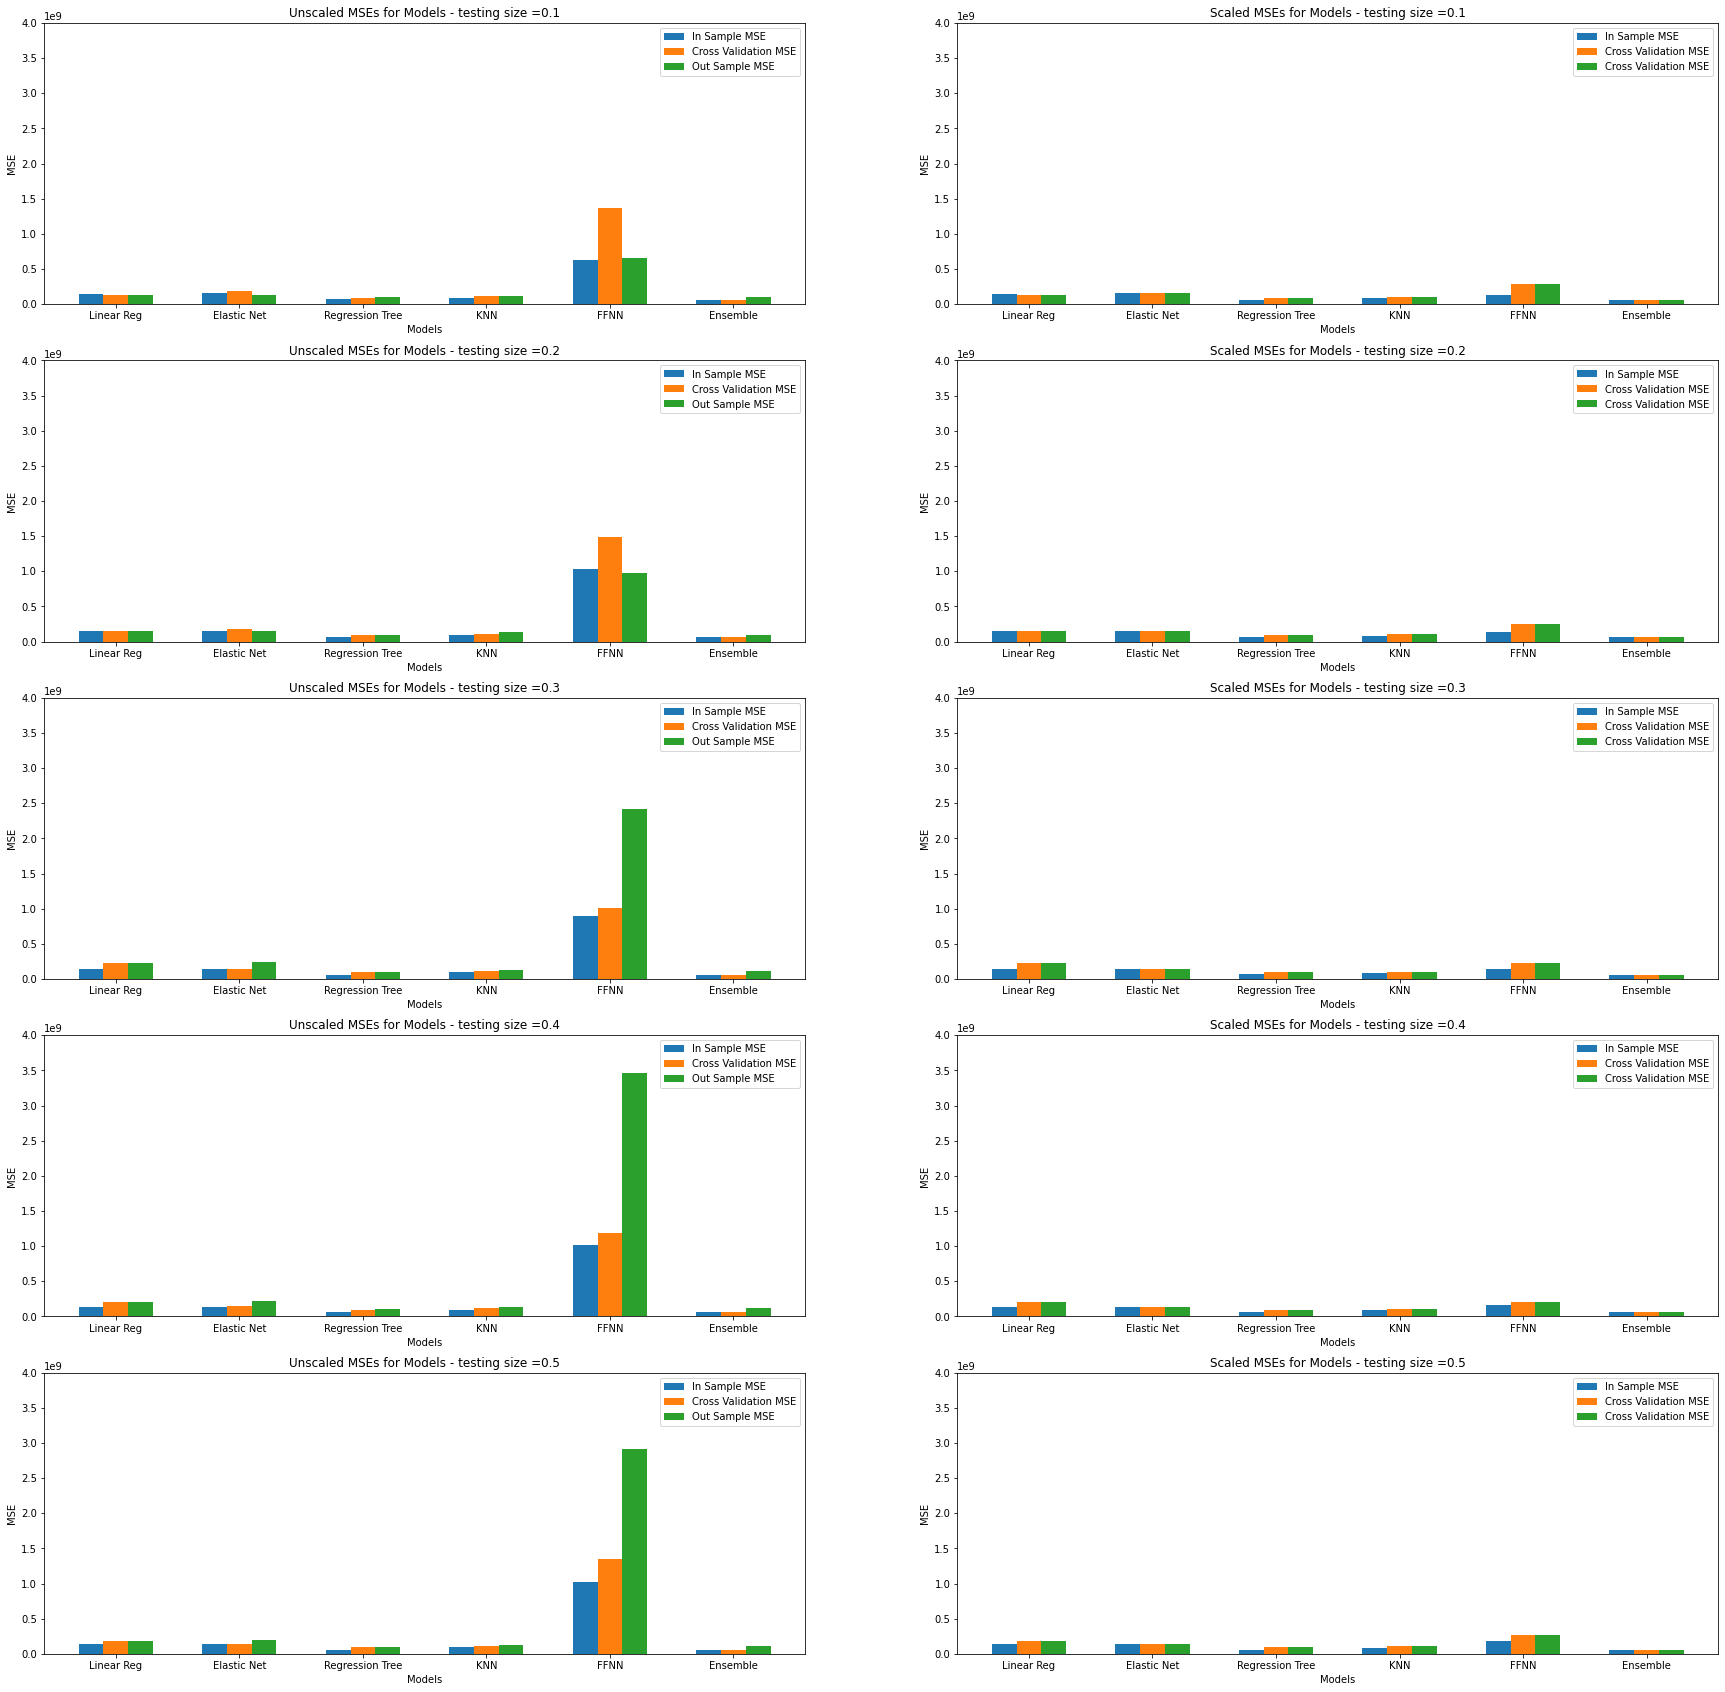

In [29]:
## Plotting MSE Scores by Models for each Testing size & Scaled Data
models = ['Linear Reg', 'Elastic Net', 'Regression Tree', 'KNN', 
          'FFNN',
          'Ensemble']
names =['Unscaled', 'Scaled']

X_axis = np.arange(len(models))

## Building Bar Charts 
fig, ax = plt.subplots(5, 2, figsize = (30, 30))
splits = [0.1, 0.2, 0.3, 0.4, 0.5]

scores = [linreg_scores, en_scores, regtree_scores, knn_scores, ffnn_scores, 
          super_scores]


# Printing Best Test Split for every Model/Data Scaled:
print('Best Test Size for Model & Scaled/Unscaled:')
for mod in range(len(scores)):
  for name in names:
    model = models[mod]
    best_split = scores[mod]['Cross_Val_MSE_{}'.format(name)].idxmin()
    print(model, name, best_split)

print('\n')

# Printing Best Scaled/Unscaled for every Model/Split Size:
print('Best Data for Model & Testing Split:')
for mod in range(len(scores)):
  for split in splits:
    model = models[mod]
    data_scale = scores[mod][['Cross_Val_MSE_Unscaled', 
                              'Cross_Val_MSE_Scaled']].loc[0.1].idxmin()

    if data_scale == 'Cross_Val_MSE_Unscaled':
      best_data = 'Unscaled'
    elif data_scale == 'Cross_Val_MSE_Scaled':
      best_data = 'Scaled'
    print(model, split, best_data)

print('\n')

print('Best Model By Test size & Data Scaled:')

# Now doing the Model Comparison & Plotting the Bar Chart:
for i in range(len(splits)):
  split = splits[i]
  in_mse_norm = []
  out_mse_norm = []
  cross_mse_norm = []
  in_mse_scale = []
  out_mse_scale = []
  cross_mse_scale = []
  for mod in range(len(scores)):
    in_mse_val = scores[mod]['In_Sample_MSE_{}'.format('Unscaled')][split]
    out_mse_val = scores[mod]['Out_Sample_MSE_{}'.format('Unscaled')][split]
    cross_mse_val = scores[mod]['Cross_Val_MSE_{}'.format('Unscaled')][split]

    in_mse_norm.append(in_mse_val)
    out_mse_norm.append(out_mse_val)
    cross_mse_norm.append(cross_mse_val)

    in_mse_val = scores[mod]['In_Sample_MSE_{}'.format('Scaled')][split]
    out_mse_val = scores[mod]['Cross_Val_MSE_{}'.format('Scaled')][split]
    cross_mse_val = scores[mod]['Cross_Val_MSE_{}'.format('Scaled')][split]

    in_mse_scale.append(in_mse_val)
    out_mse_scale.append(out_mse_val)
    cross_mse_scale.append(cross_mse_val)

  # Printing the Best Model by split size and Scaled/Unscaled Data
  scaled_model = models[pd.DataFrame(cross_mse_scale).idxmin()[0]]
  unscaled_model = models[pd.DataFrame(cross_mse_norm).idxmin()[0]]

  print(split, 'scale', scaled_model)
  print(split, 'unscale', unscaled_model)
  
  # Plotting the Bar Charts
    # The left column (column 0) are all for Unscaled Data
    # The Right Column (column 1) are all for the Scaled Data
    # Every Row represents a different testing set size:
      # Row 0: 10%
      # Row 1: 20%
      # Row 2: 30%
      # Row 3: 40%
      # Row 4: 50%
    # Within Every plot, the MSEs for every model are plotted for the 
    # corresponding testing set size and data. For each model, we are plotting
    # its In-Sample MSE (training error), Cross-Validation MSE (used for 
    # validation & model comparison), and Out-of-Sample MSE 


  # Column 0 -- Unscaled Data
  ax[i, 0].bar(X_axis - 0.2, in_mse_norm, 0.2, label = 'In Sample MSE')
  ax[i, 0].bar(X_axis, cross_mse_norm, 0.2, label = 'Cross Validation MSE')
  ax[i, 0].bar(X_axis + 0.2, out_mse_norm, 0.2, label = 'Out Sample MSE')

  ax[i, 0].set_xticks(X_axis, models)
  ax[i, 0].set_ylim(ymin = 0, ymax = 4.0e9)
  ax[i, 0].set_title('Unscaled MSEs for Models - testing size ={}'.format(split))
  ax[i, 0].set_ylabel("MSE")
  ax[i, 0].set_xlabel('Models')
  ax[i, 0].legend()


  # Column 1 - Scaled Data 
  ax[i, 1].bar(X_axis - 0.2, in_mse_scale, 0.2, label = 'In Sample MSE')
  ax[i, 1].bar(X_axis, cross_mse_scale, 0.2, label = 'Cross Validation MSE')
  ax[i, 1].bar(X_axis + 0.2, out_mse_scale, 0.2, label = 'Cross Validation MSE')

  ax[i, 1].set_ylim(ymin = 0, ymax = 4.0e9)
  ax[i, 1].set_xticks(X_axis, models)
  ax[i, 1].set_title('Scaled MSEs for Models - testing size ={}'.format(split))
  ax[i, 1].set_ylabel("MSE")
  ax[i, 1].set_xlabel('Models')
  ax[i, 1].legend()

plt.show()

In [30]:
# Finding the best performing model Overall by minimum Cross-Validation MSE

# Creating a List of all the different Model results tables 
scores = [linreg_scores, en_scores, regtree_scores, knn_scores, ffnn_scores, 
          super_scores]

# List of the Names of the Models 
models = ['Linear Reg', 'Elastic Net', 'Regression Tree', 'KNN', 
          'FFNN1',
          'Ensemble']

# List of all split sizes 
splits = [0.1, 0.2, 0.3, 0.4, 0.5]

# Initializing empty list to store results
min_mse_normal = []
min_mse_scale = []
best_splits_norm = []
best_splits_scale = []

# Looping through every model to find the minimum CV MSE for both scaled
  # unscaled data
for i in range(len(scores)):
  # Unscaled Data - Minimum MSE fo the Model & corresponding best split
  min_mse_normal.append(scores[i]['Cross_Val_MSE_Unscaled'].min())
  best_splits_norm.append(scores[i]['Cross_Val_MSE_Unscaled'].idxmin())

  # Scaled Data - Minimum MSE fo the Model & corresponding best split
  min_mse_scale.append(scores[i]['Cross_Val_MSE_Scaled'].min())
  best_splits_scale.append(scores[i]['Cross_Val_MSE_Scaled'].idxmin())

# Finding the Minimum MSE over all Models for Unscaled Data & Corresponding 
  # Best Split
minimum_mse_norm = np.min(min_mse_normal)
best_model_normal = models[min_mse_normal.index(minimum_mse_norm)]
best_split_normal = best_splits_norm[min_mse_normal.index(minimum_mse_norm)]

  # Printing Results 
print('Unscaled:')
print('Lowest MSE:', minimum_mse_norm)
print('Best Split:', best_split_normal)
print('Best Model:', best_model_normal)
print('\n')

# Finding the Minimum MSE over all Models for Scaled Data & Corresponding 
  # Best Split
minimum_mse_scale = np.min(min_mse_scale)
best_model_scale = models[min_mse_scale.index(minimum_mse_scale)]
best_split_scale = best_splits_scale[min_mse_scale.index(minimum_mse_scale)]
  # Printing Results 
print('Scaled:')
print('Lowest MSE:', minimum_mse_scale)
print('Best Split:', best_split_scale)
print('Best Model:', best_model_scale)

print('\n')

# Finding the Minimum MSE over all Models & Corresponding Best Split
print('Best Model Overall:')
best_mse = min(minimum_mse_norm, minimum_mse_scale)
if best_mse == minimum_mse_norm:
  print('Unscaled:')
  print('Lowest MSE:', minimum_mse_norm)
  print('Best Split:', best_split_normal)
  print('Best Model:', best_model_normal)
else:
  print('Scaled:')
  print('Lowest MSE:', minimum_mse_scale)
  print('Best Split:', best_split_scale)
  print('Best Model:', best_model_scale)


Unscaled:
Lowest MSE: 56099740.00547967
Best Split: 0.5
Best Model: Ensemble


Scaled:
Lowest MSE: 56898286.610535756
Best Split: 0.5
Best Model: Ensemble


Best Model Overall:
Unscaled:
Lowest MSE: 56099740.00547967
Best Split: 0.5
Best Model: Ensemble


### Test Model & Evaluation -- WITH FINAL MODEL 

#### Model Weights 

In [31]:
pd.DataFrame(super_scores.iloc[-1, 11:])

,0.5
Linear_Scaled,1.144200
Elastic_Net_Scaled,-6.654107
KNN_Scaled,0.082363
RegressionTree_Scaled,6.474351
FFNN_Scaled,-0.041836


#### In sample and out of sample MSE

In [32]:
pd.DataFrame(super_scores.iloc[-1, 8:11:2])

,0.5
In_Sample_MSE_Scaled,5.606526e+07
Out_Sample_MSE_Scaled,9.976328e+07


#### In sample and out of sample MAE

In [33]:
pd.DataFrame(super_scores2.iloc[-1, 8:10])

,0.5
In_Sample_MAE_Scaled,6308.181382
Out_Sample_MAE_Scaled,8091.392148


#### In sample and out of sample R Squared

In [34]:
pd.DataFrame(super_scores2.iloc[1, 10:])

,0.2
In_Sample_R2_Scaled,0.676441
Out_Sample_R2_Scaled,0.486866


In [35]:
MSE = np.array(super_scores.iloc[-1, 8:11:2])
MAE = np.array(super_scores2.iloc[-1, 8:10])
R2 = np.array(super_scores2.iloc[1, 10:])

pd.DataFrame({'Mean Squared Error': MSE,
              'Mean Absolute Error': MAE,
              'R-Squared': R2},
             index = ['In-Sample', 'Out-of-Sample'])

,Mean Squared Error,Mean Absolute Error,R-Squared
In-Sample,5.606526e+07,6308.181382,0.676441
Out-of-Sample,9.976328e+07,8091.392148,0.486866
